# Unsupervised Graph Learning

Unsupervised ML: subset of ML that do not exploit any target information during training. Where there is no teacher and no correct answer is known a *priori*. These have become a useful tool to solve downstream tasks, such as node classification, community detection etc..

Given a graph, the goal of the techniques is to automatically learn a latent representation of it, in which the key structural components are somehow preserved.

Due to the mathematical complexity of Graphs in non-Euclidean space, it is not always easy to define what is close to what. May be hard to say what *close* even means, two users can be connected yet share very different features, can we still consider them as "close"? So problems like these are the reason unsupervised ML algorithms have found large applications in graph analysis, as there is no need for manually annotated data; making use of the information in the adjacency matrix and node features without any knowledge of the downstream ML task.

One of the most used solutions is to learn embeddings that preserve graph structure. Learned representation can reconstruct pair-wise node similarity e.g. **adjacency matrix**. Can encode latent relationships to discover hidden and complex patterns. Reported by paper https://arxivorg/abs/2005.03675, algorithms can be grouped into macro-groups: shallow embedding methods, autoencoders and GNNs. 

![3_1](./figures/3_1.jpg)

## Shallow Embedding Methods
Learn and return embedding values for learned input data

### Matrix Factorisation
General decomposition technique widely used in different domains. Consistent number of graph embedding algorithms use this technique to compute node embedding of a graph.
Matrix factorisation learns the V and H matrices (W ~ V X H) where $V \isin \Re$ <sup>$m$ x $d$</sup> and  $H \isin \Re$ <sup>$d$ x $n$</sup> (called **source** and **abundance** matrix respectively) by minimising a loss function that can change according to the specific problem we want to solve. *d* is the number of dimensions of the generated embedding space. The loss fn. is defined by computing the reconstruction err. using the Frobenius Norm as $||W - V X H||^2_F$. 

Generally speaking, all the unsupervised embedding algorithms based on matrix factorisation use the same principle. They factorise an input graph expressed as a matrix in different components. Differences lie in the loss functions used in the optimisation process. Different loss functions create embedding spaces that emphasise specific graph properties.

### Graph Factorisation
GF algorithm factorises the adjacency matrix of a given graph. 
$L = 1/2 \sum\limits_{(i,j) \isin E} (A$ <sub>$i,j$</sub> $- Y_i,Y_j^T)^2 + \lambda/2 \sum\limits_{i}||Y_t||^2$
May also include a regularisation term $\lambda$ to make sure the problem remains well-posed in the absence of sufficient data. Suitable for undirected graph, has a strong symmetric factorisation. But could be limited for undirected graphs.

In [1]:
import networkx as nx
from gem.embedding.gf import GraphFactorization

G = nx.barbell_graph(m1=10, m2=4)

# generate d=2 dimensional embedding space
gf = GraphFactorization(d=2, data_set=None, max_iter=10000, eta=1*10**-4, regu=1.0)
# computation of node embeddings of input graph
gf.learn_embedding(graph=G)
# extracted computed embedding by calling gf.get_embedding()
embeddings = gf.get_embedding()

[Errno 2] No such file or directory: 'gem/c_exe/gf'
./gf not found. Reverting to Python implementation. Please compile gf, place node2vec in the path and grant executable permission
		Iter id: 0, Objective: 95.0074, f1: 95.0032, f2: 0.00421903


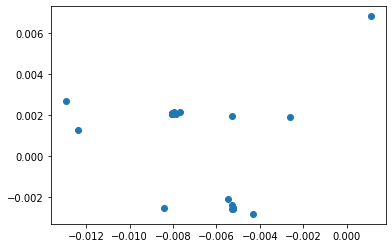

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# we can see approx. 3 groupings
plt.scatter(embeddings[:,0], embeddings[:,1])

**Higher-order proximity preserved embedding (HOPE)** is another graph embedding technique based on matrix factorisation. This method preserves higher-order proximity and does not force its embeddings to have symmetric properties.
-  **First-order proximity**: We say a vertex pair $(v_i, v_j)$ has first-order proximity equal to edge weight $W$<sub>$ij$</sub> if edge $(v_i, v_j) \isin E$. Otherwise, the first-order proximity between the two nodes is 0.
-  **Second and high-order proximity**: Capture two-step relationships between each pair of vertices. For each vertex pair $(v_i, v_j)$, second-order proximity is a two-step transition from $v_i$ to $v_j$. Higher-order proximity generalises this and we can capture a more global structure. Higher-order proximity can be viewed as k-step transition from $v_i$ to $v_j$.

Loss function for HOPE is $L = ||S - Y_s \times Y_t^T||^2_F$ where $S$ is the similarity matrix from graph $G$ and $Y_s \isin \Re$<sup>$|V|xd$</sup> and $Y_t \isin \Re$<sup>$|V|xd$</sup> are two ebedding matrices representing *d*-dimensional embedding space. $Y_s$ represents source embedding and $Y_t$ represents target embedding. HOPE uses two matrices to capture asymmetric proximity in directed networks where the direction from source node and target node is present. The final embedding matrix, Y, is obtained by concatenating column-wise $Y_s$ and $Y_t$ matrices, so the final embedding space has $2 * d$ dimensions.

*S* is a similarity matrix from graph *G*, it's goalis to obtain higher-order proximity information. Formally computed as $S=M_g \cdot M_t$ where $M_g$ and $M_t$ are polynomials of matrices. Some ways to compute $M_g$ and $M_t$ are:
-  **Academic Adar(AA)**: Here, $M_g = I (identity)$ and $M_t = A \cdot D \cdot A$ where $D$ is a diagonal matrix computed as $D$<sub>$ij$</sub> $ = 1/ (\sum (A_i $<sub>$j$</sub> $+ A_j$ <sub>$i$</sub> $))$
-  **Katz Index**
-  **Rooted PageRank (RPR)**
-  **Common Neighbors (CN)** etc..

In [3]:
import networkx as nx
from gem.embedding.hope import HOPE

G = nx.barbell_graph(m1=10, m2=4)
# different class initialization with HOPE
# d represents dimension of embedding space, num of columns of final embedding matrix Y
# Y is obtained after column-wise concatenation of Y_s and Y_t
gf = HOPE(d=4, beta=0.01)
gf.learn_embedding(graph=G)
embeddings = gf.get_embedding()

SVD error (low rank): 0.052092


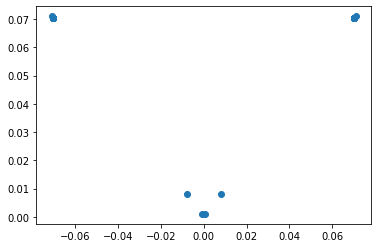

In [4]:
# can see better grouping/separation of models
plt.scatter(embeddings[:,0], embeddings[:,1])

**Graph Representation with Global Structure Information**

Graph representation with global structure information, such as HOPE allows us to preserve higher-order proximity without forcing embeddings to have symmetric properties. Formally, let $G = (V, E)$ be the graph we want to compute node embeddings for and $A \isin \Re$<sup>$|V| \times |V|$</sup> be its adjacency matrix, we have the loss function:
$L_k = ||X^k - Y_s^k \times Y_t $<sup>$k^T$</sup>$||^2_F 1 \le k \le K $. In the loss fn, $X^k \isin \Re$<sup>$|V|\times|V|$</sup> is a matrix generated from graph *G* to get the *k*th order of proximity between nodes. 

$Y_s^k \isin \Re$<sup>$|V|\times|V|$</sup> and $Y_t^k \isin \Re$<sup>$|V|\times|V|$</sup> are two embedding matrices representing a d-dimensional embedding space of *k*th order proximity for source and target nodes, respectively.